
# Hanacaraka Handrwiting Detection Using Fine Tuned Resnet50V2

Data are taken from 2 source in kaggle
> https://www.kaggle.com/datasets/hannanhunafa/javanese-script-aksara-jawa-augmented
> https://www.kaggle.com/datasets/vzrenggamani/hanacaraka

## Import Libary

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


## Reading Data

In [181]:
PATH = './hanacaraka/'
images, labels = [], []
for dirname, _, filenames in os.walk(PATH):
  for filename in filenames:
    images.append(os.path.join(dirname, filename)) # /folder/blabla/xxx.jpg
    labels.append(os.path.join(dirname, filename).split('\\')[0].split('/')[2])

In [182]:
label = np.unique(labels)
label

array(['LICENSE', 'LICENSE.md', 'README.md', 'ba', 'ca', 'da', 'dha',
       'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra',
       'sa', 'ta', 'tha', 'wa', 'ya'], dtype='<U10')

In [183]:
label = np.delete(label, [0, 1, 2])
images = np.delete(images, [0, 1, 2])
labels = np.delete(labels, [0, 1, 2])
len(label)

20

In [184]:
print(f"Length of Labels {len(labels)}")
len(images)

Length of Labels 13580


13580

In [ ]:
temp_image = []
image_train = []
label_train = []
img_size = 224
count = 0

for i in images : 
    
    img = cv2.imread(i)
    if img is None:
        print(f"Failed to load image: {i}")
        continue
    temp_image.append(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(img_size,img_size))
    image_train.append(img)
    label_train.append(labels[count])
    count+=1

Failed to load image: ./hanacaraka/dha\4696038101413220221_base64_32.png
Failed to load image: ./hanacaraka/dha\4697111846216686148_base64_32.png
Failed to load image: ./hanacaraka/ga\4696394596413810473_base64_43.png
Failed to load image: ./hanacaraka/ha\4694803355817399930_base64_5.png
Failed to load image: ./hanacaraka/ja\4694023059412567494_base64_34.png
Failed to load image: ./hanacaraka/la\4695952290615665559_base64_27.png
Failed to load image: ./hanacaraka/nya\4695963539838682931_base64_38.png
Failed to load image: ./hanacaraka/pa\4694579845264951891_base64_30.png
Failed to load image: ./hanacaraka/pa\4696000994938205989_base64_30.png
Failed to load image: ./hanacaraka/ra\4693979959028129056_base64_14.png.fdmdownload
Failed to load image: ./hanacaraka/ra\4694221966812671068_base64_14.png
Failed to load image: ./hanacaraka/ra\4695660931512476490_base64_14.png
Failed to load image: ./hanacaraka/ra\4695874552811358083_base64_14.png
Failed to load image: ./hanacaraka/ta\469340352131

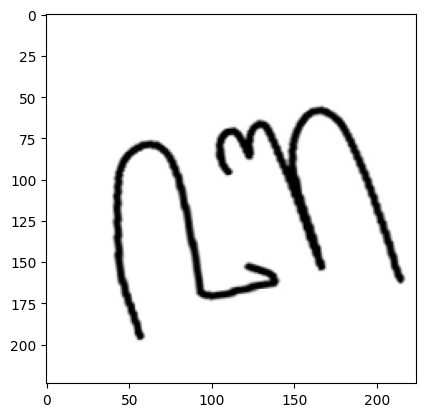

In [186]:
plt.imshow(image_train[300], cmap="gray")

## Data Splitting

70 : 15 : 15 - Train : Validation : Test

In [187]:
data = pd.DataFrame({'image_path':temp_image, 'label':label_train})
data.head()

,image_path,label
0,./hanacaraka/ba\4693335674404368252_base64_45.png,ba
1,./hanacaraka/ba\4693340161012711825_base64_45.png,ba
2,./hanacaraka/ba\4693350885715757021_base64_45.png,ba
3,./hanacaraka/ba\4693358261014228548_base64_45.png,ba
4,./hanacaraka/ba\4693360511011442821_base64_45.png,ba


In [188]:
df_train, df_validation = train_test_split(data, test_size=0.3, stratify=data['label'], random_state=42)
df_validation, df_test = train_test_split(df_validation, test_size=0.5, stratify=df_validation['label'], random_state=42)

In [189]:
df_train['label'].value_counts()

label
ha     476
nga    476
la     476
ca     476
ba     476
ra     475
nya    475
da     475
ga     475
ja     475
ta     475
ka     475
ma     475
wa     475
dha    475
na     475
tha    475
pa     475
sa     475
ya     463
Name: count, dtype: int64

## Data Image Generator and Augmentation

In [ ]:
target_size = 224
batch_size = 32

train_dataGen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=[0.9, 1.0],
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        preprocessing_function=preprocess_input)

val_dataGen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_dataGen.flow_from_dataframe(
    df_train,
    x_col='image_path',
    y_col='label',
    target_size=(target_size, target_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    classes=sorted(df_train['label'].unique())
)

val_generator = val_dataGen.flow_from_dataframe(
    df_validation,
    x_col='image_path',
    y_col='label',
    target_size=(target_size, target_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    classes=sorted(df_train['label'].unique())
)

test_generator = val_dataGen.flow_from_dataframe(
    df_test,
    x_col='image_path',
    y_col='label',
    target_size=(target_size, target_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    classes=sorted(df_train['label'].unique())
)

Found 9493 validated image filenames belonging to 20 classes.
Found 2034 validated image filenames belonging to 20 classes.
Found 2035 validated image filenames belonging to 20 classes.


In [191]:
feature, target = next(iter(train_generator))
feature.shape, len(train_generator)

((32, 224, 224, 3), 297)

## Model Training

In [ ]:
base_model =ResNet50V2(weights='imagenet', include_top=False, input_shape=(224,224,3))

base_model.trainable = False  

model = Sequential([
    InputLayer(input_shape=(224, 224, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5), 
    Dense(20, activation='softmax')
])

model.summary()

d:\binus\Kuliah sem 5\DL\Hancakaraka\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_13     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 20)             │         5,140 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,094,484 (91.91 MB)

 Trainable params: 529,684 (2.02 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [193]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3
)

In [200]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - accuracy: 0.6152 - loss: 2.0416 - val_accuracy: 0.8053 - val_loss: 1.6015 - learning_rate: 1.0000e-04
Epoch 2/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 304s 1s/step - accuracy: 0.6536 - loss: 1.8314 - val_accuracy: 0.8274 - val_loss: 1.4294 - learning_rate: 1.0000e-04
Epoch 3/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 317s 1s/step - accuracy: 0.6819 - loss: 1.6660 - val_accuracy: 0.8427 - val_loss: 1.3224 - learning_rate: 1.0000e-04
Epoch 4/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 313s 1s/step - accuracy: 0.6916 - loss: 1.5889 - val_accuracy: 0.8471 - val_loss: 1.2495 - learning_rate: 1.0000e-04
Epoch 5/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/step - accuracy: 0.7052 - loss: 1.4916 - val_accuracy: 0.8407 - val_loss: 1.1692 - learning_rate: 1.0000e-04
Epoch 6/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - accuracy: 0.7153 - loss: 1.4180 - val_accuracy: 0.8618 - val_loss: 1.1024 - learning_rate: 1.0000e-04
Epoch 7/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 319s 1s/ste

In [201]:
for layer in base_model.layers[-40:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 475s 2s/step - accuracy: 0.7576 - loss: 1.0392 - val_accuracy: 0.9066 - val_loss: 0.5268 - learning_rate: 1.0000e-05
Epoch 2/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 454s 2s/step - accuracy: 0.8774 - loss: 0.6179 - val_accuracy: 0.9366 - val_loss: 0.4408 - learning_rate: 1.0000e-05
Epoch 3/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 472s 2s/step - accuracy: 0.9067 - loss: 0.5206 - val_accuracy: 0.9430 - val_loss: 0.4081 - learning_rate: 1.0000e-05
Epoch 4/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 467s 2s/step - accuracy: 0.9250 - loss: 0.4560 - val_accuracy: 0.9523 - val_loss: 0.3769 - learning_rate: 1.0000e-05
Epoch 5/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 433s 1s/step - accuracy: 0.9344 - loss: 0.4215 - val_accuracy: 0.9513 - val_loss: 0.3708 - learning_rate: 1.0000e-05
Epoch 6/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 430s 1s/step - accuracy: 0.9408 - loss: 0.3999 - val_accuracy: 0.9592 - val_loss: 0.3463 - learning_rate: 1.0000e-05
Epoch 7/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 430s 1s/ste

## Model Evaluation

In [202]:
model.evaluate(test_generator)[1]*100

d:\binus\Kuliah sem 5\DL\Hancakaraka\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 54s 840ms/step - accuracy: 0.9686 - loss: 0.2463


96.85503840446472

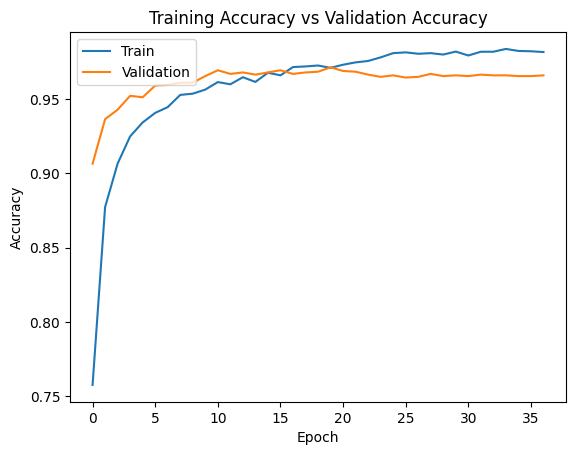

In [203]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
test_generator.reset()
y_pred_probs = model.predict(test_generator)  
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = test_generator.classes  

class_labels = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))


64/64 ━━━━━━━━━━━━━━━━━━━━ 57s 875ms/step
              precision    recall  f1-score   support

          ba       0.99      1.00      1.00       102
          ca       0.99      0.99      0.99       102
          da       0.99      0.98      0.99       102
         dha       1.00      0.98      0.99       102
          ga       0.89      0.96      0.92       102
          ha       1.00      0.93      0.96       102
          ja       0.99      0.99      0.99       102
          ka       0.98      0.99      0.99       102
          la       0.99      0.96      0.97       101
          ma       1.00      1.00      1.00       102
          na       0.98      0.96      0.97       102
         nga       0.96      0.97      0.97       101
         nya       0.98      0.98      0.98       102
          pa       0.98      0.99      0.99       102
          ra       0.92      1.00      0.96       102
          sa       0.99      0.88      0.93       102
          ta       0.96      0.94      

{0: np.str_('ba'), 1: np.str_('ca'), 2: np.str_('da'), 3: np.str_('dha'), 4: np.str_('ga'), 5: np.str_('ha'), 6: np.str_('ja'), 7: np.str_('ka'), 8: np.str_('la'), 9: np.str_('ma'), 10: np.str_('na'), 11: np.str_('nga'), 12: np.str_('nya'), 13: np.str_('pa'), 14: np.str_('ra'), 15: np.str_('sa'), 16: np.str_('ta'), 17: np.str_('tha'), 18: np.str_('wa'), 19: np.str_('ya')}


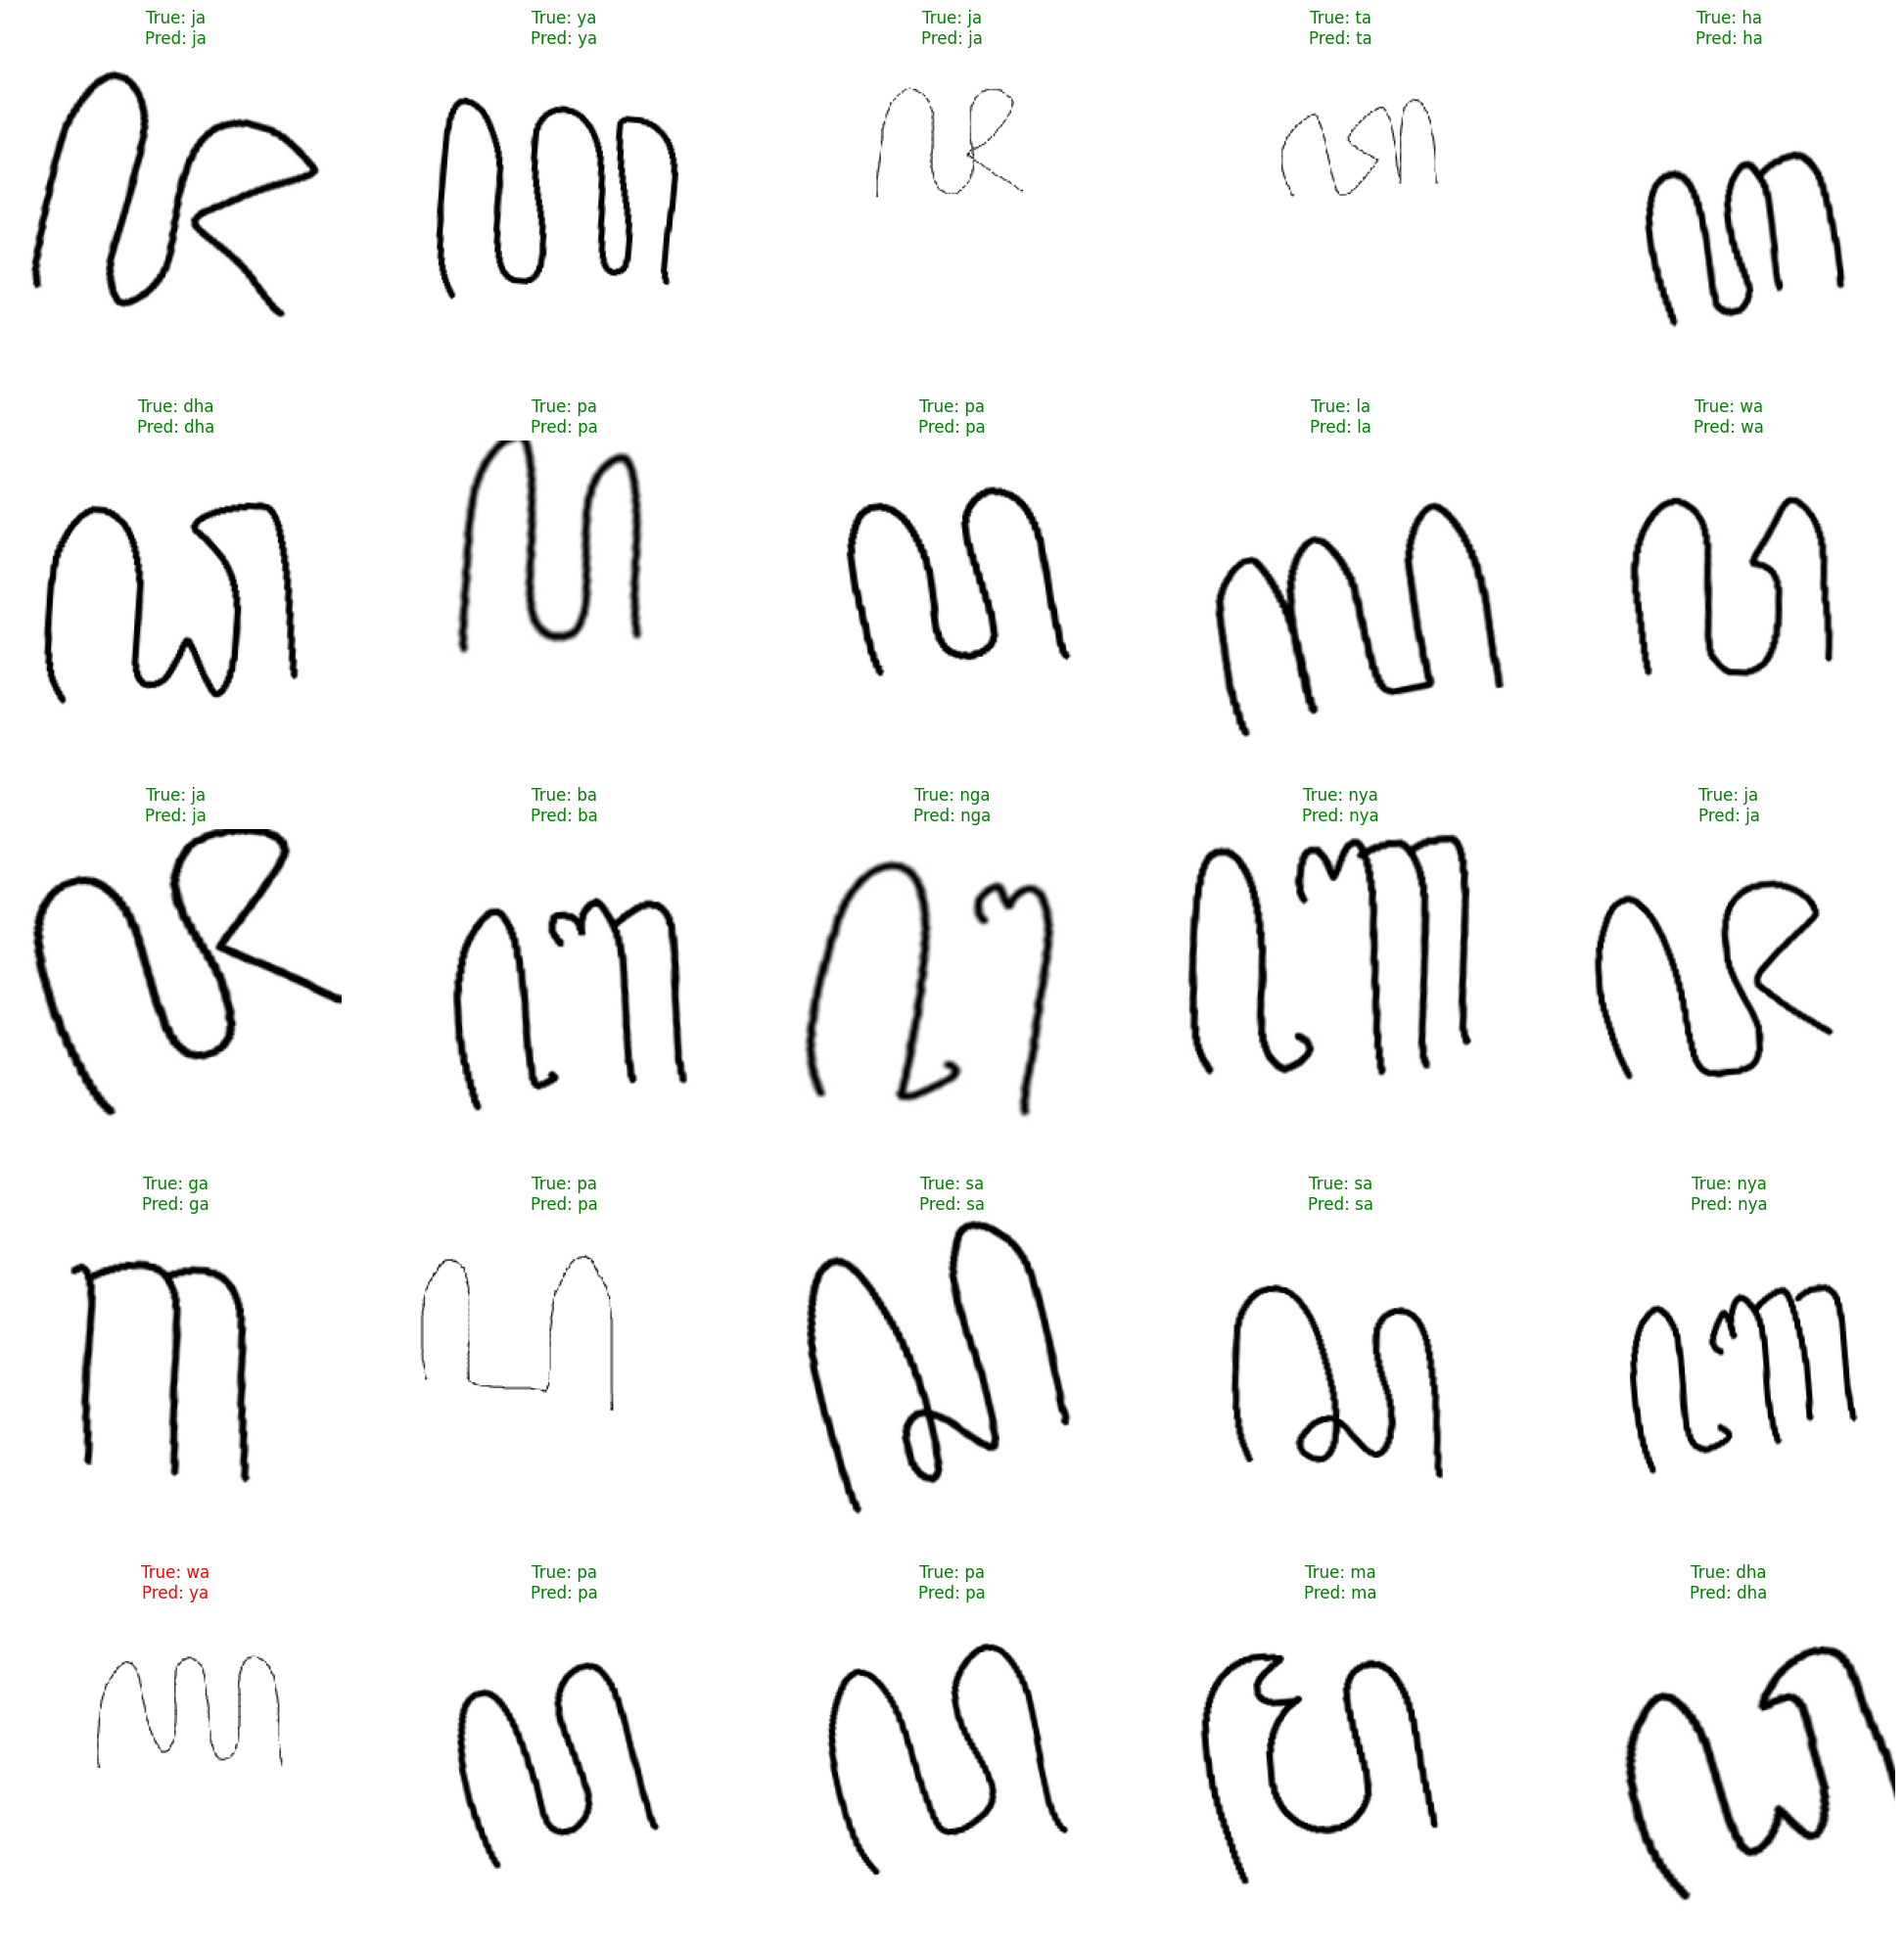

In [266]:
sample_df = data.sample(25).reset_index(drop=True)
img_size = (224, 224)

label_map = {v: k for k, v in test_generator.class_indices.items()}
print(label_map)
plt.figure(figsize=(20, 20))

for i in range(len(sample_df)):
    img_path = sample_df['image_path'][i]
    label = sample_df['label'][i]

    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    pred_probs = model.predict(img_array, verbose=0)[0]
    pred_label = np.argmax(pred_probs)
    pred_label = label_map[pred_label]

    color = 'green' if pred_label == label else 'red'

    plt.subplot(5,5,i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'True: {label}\nPred: {pred_label}', color=color)

plt.tight_layout()
plt.show()


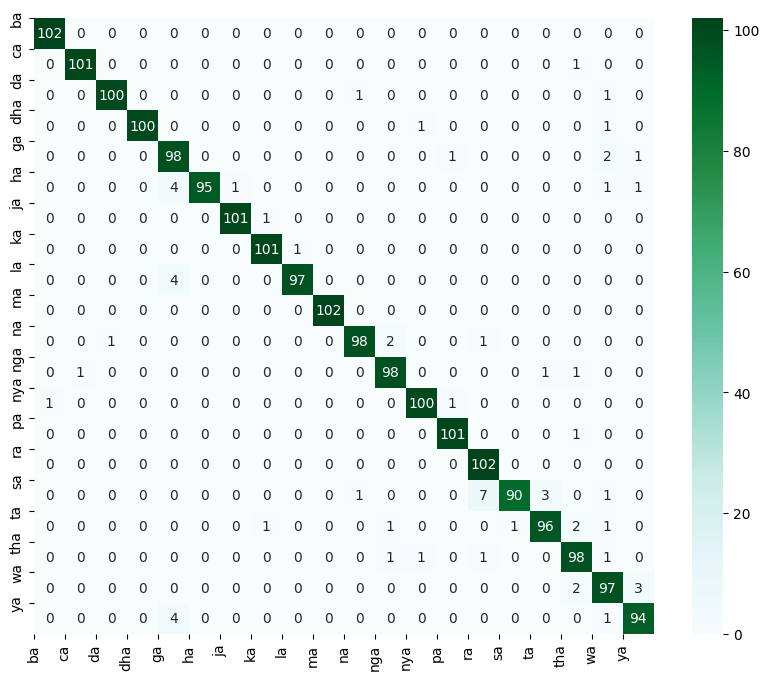

In [267]:
plt.figure(figsize=(10,8))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='BuGn')
plt.xticks(ticks=np.arange(0, len(list(label_map.keys()))), labels = list(label_map.values()), rotation=90)
plt.yticks(ticks=np.arange(0, len(list(label_map.keys()))), labels = list(label_map.values()))

plt.show()

64/64 ━━━━━━━━━━━━━━━━━━━━ 57s 886ms/step


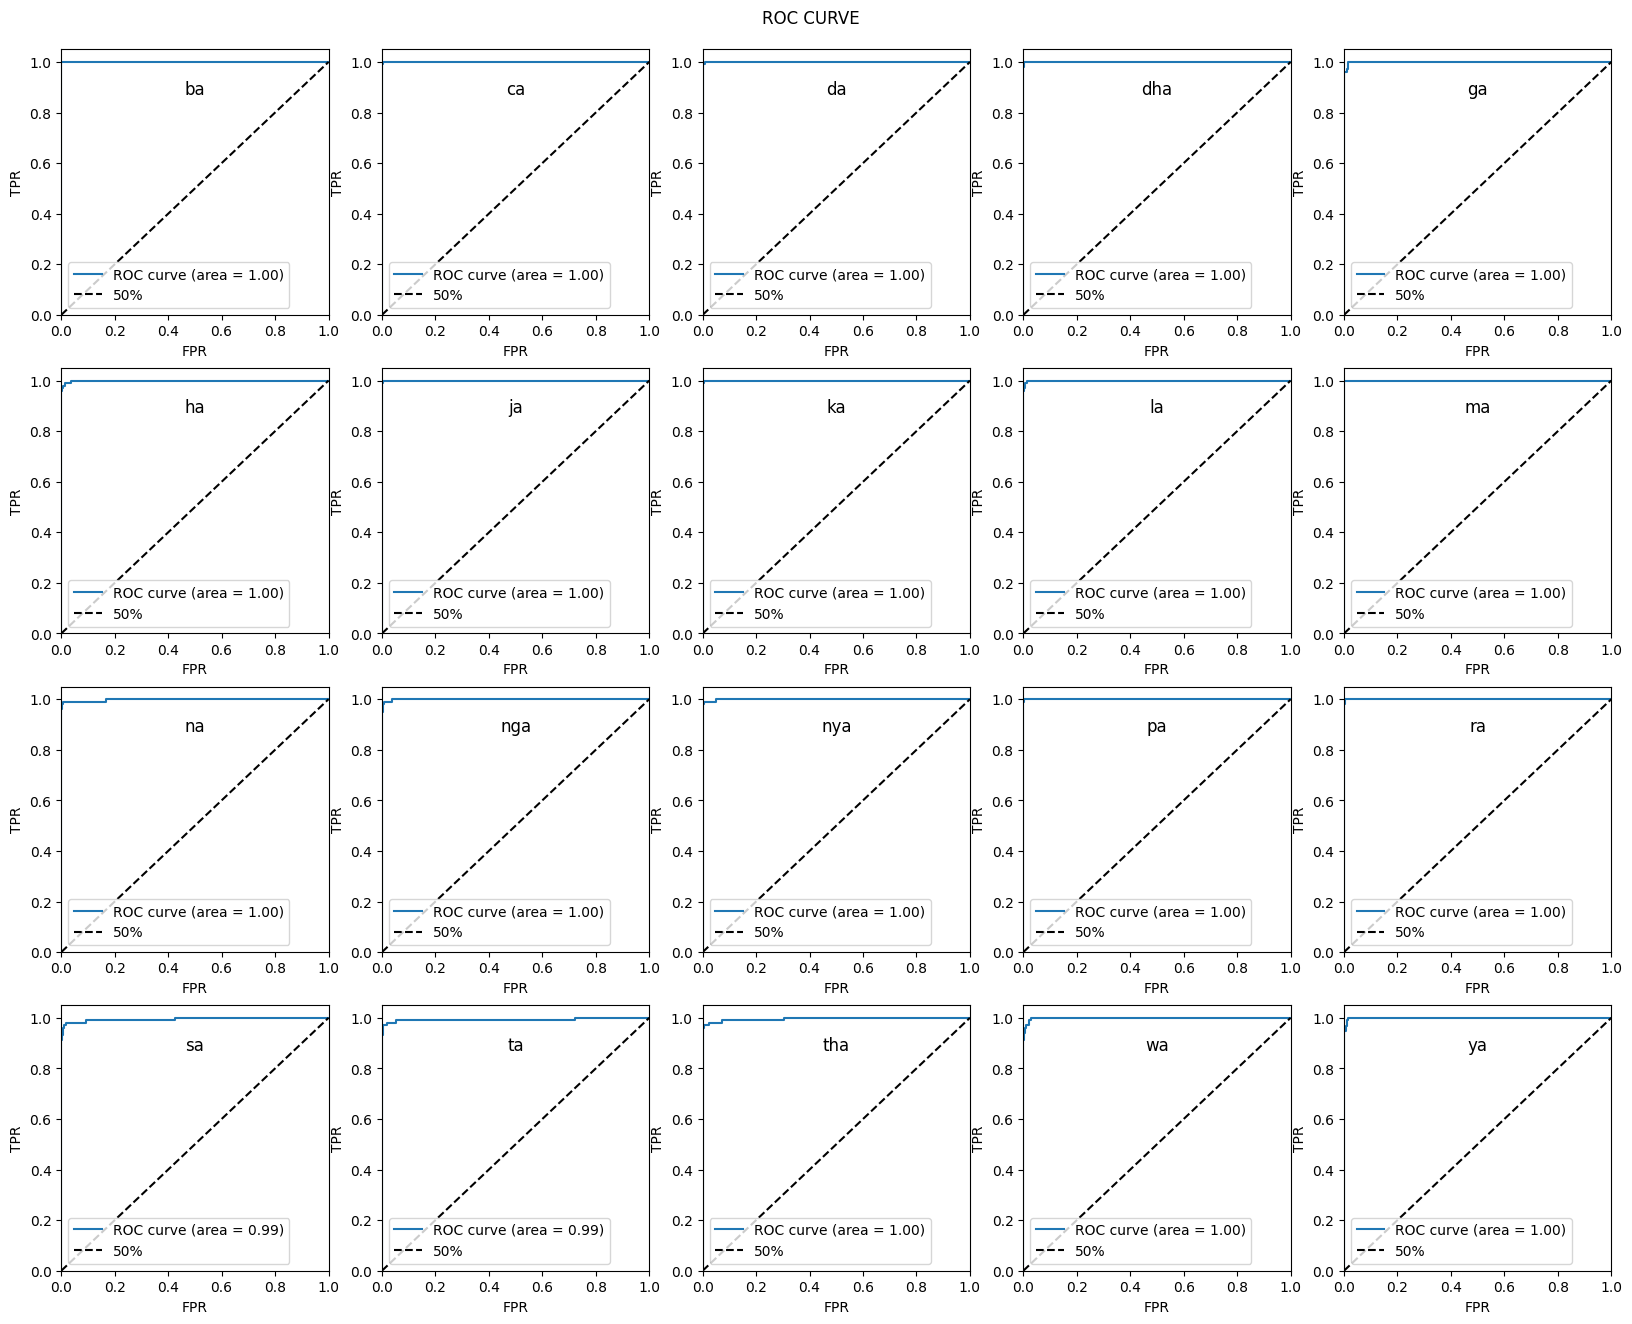

In [ ]:
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, verbose=1) 
class_names = list(test_generator.class_indices.keys())
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=range(n_classes))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i],tpr[i],_ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(20,20)) 
plt.suptitle("ROC CURVE", y=0.9) 
for i in range(n_classes):
    plt.subplot(5,5,i+1)
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--', label='50%')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'{class_names[i]}', y=0.8)
    plt.legend()
plt.show()

## Model and Class Label Saving

In [ ]:
model.save('ResNet50-FineTune-40Fl.keras')

In [284]:
import pickle as p
file = open('class-indicies.pkl', 'wb')
p.dump(list(test_generator.class_indices.items()), file)